# Objective:

Assign a filament/filament_id field to a cryoSPARC passthrough file to use with refinements. This metadata field is not set when using blob or template picking in cryoSPARC for filaments. It is better to use the cryoSPARC Filament Tracer if possible to assign this field, but nevertheless this notebook contains a stopgap for scenarios in which the Filament Tracer fails.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cryosparc.tools as cs
import ipywidgets as widgets # for slider plot, needed to use -c conda-forge and then enable the nbextensions

from itertools import combinations
from collections import Counter
from IPython.display import display

In [2]:
# This makes plotting a tad easier, especially for the interactive plot at the end.
%matplotlib notebook

### Functions:

The general premise is to:
1) Find pairs of points satisfying a maximum distance threshold
2) Build chains from intersecting pairs
3) Map chain/filament IDs to particle UIDs

Note: The simple distance-based clustering is not very robust and does not handle intersecting filaments appropriately (i.e., if two filaments overlap, then they will be assigned to the same filament ID)

In [3]:
# function definitions

def make_dataframe_list(dataframe,separation_field):
    """
    Function: Separates a dataframe based on a specified column/field
    Input: pd.df, str
    Output: list
    """
    df_list = []
    for ind in set(dataframe[separation_field]):
        df = dataframe[dataframe[separation_field]==ind]
        df_list.append(df)
    return df_list

def euclidean_distance(p1, p2):
    """
    Function: Compute the distance between X/Y pairs
    Input: tuple,tuple
    Output: float
    """
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def find_pairs(points, distance_threshold):
    """
    Function: Find pairs within a distance threshold and records the uids
    Input: tuple,int
    Output: list
    """
    
    uid_pairs_list = []
    
    # compute the distance matrix for the current micrograph
    for pair in combinations(points,2):
        p1,p2 = pair
        if euclidean_distance(p1,p2) <= distance_threshold:
            uid_pairs_list.append((p1[2],p2[2])) # store uids of pairs within threshold
    
    return uid_pairs_list

def chains_from_pairs(uids,uid_pairs_list):
    """
    Function: Build chains from intersecting pairs
    Input: list,list
    Output: dict
    """
    # initialize a dictionary to keep track of uid assignment to chains
    uid_to_chain = {uid: None for uid in uids}
    
    chain_id = 0
    for pair in uid_pairs_list:
        p1,p2 = pair
        chain_p1 = uid_to_chain[p1]
        chain_p2 = uid_to_chain[p2]
        
        # assign chain based on whether one of uids has a chain assignment
        if chain_p1 is None and chain_p2 is None:
            # create a new chain for the pair
            chain_id += 1
            uid_to_chain[p1] = chain_id
            uid_to_chain[p2] = chain_id
        elif chain_p1 is not None and chain_p2 is None:
            # assign p2 to chain_p1
            uid_to_chain[p2] = chain_p1
        elif chain_p1 is None and chain_p2 is not None:
            # assign p1 to chain_p2
            uid_to_chain[p2] = chain_p2
        elif chain_p1 != chain_p2:
            # merge chain_p2 into chain_p1
            for uid, old_id in uid_to_chain.items():
                if old_id == chain_p2:
                    uid_to_chain[uid] = chain_p1
    
    return uid_to_chain


def renumber_chains(uid_to_chain):
    """
    Function: Renumber chain_ids, so that chains are continous within a micrograph
    Input: dict
    Output: dict
    """
    # renumber chains to be continous within a micrograph
    # build rechaining dictionary:
    renumbering_dict = {old_id:new_id+1 for new_id,old_id in enumerate(set(uid_to_chain.values())) if old_id is not None}
    
    if not renumbering_dict:  # check in the case there are no chains assigned in the current micrograph
        none_ids = 0
    else:
        none_ids = max(renumbering_dict.values()) # extend indices for points not assigned to chains
        
    # renumber chains
    for uid,old_id in uid_to_chain.items():
        if old_id is None:
            none_ids += 1
            uid_to_chain[uid] = none_ids
        else:
            uid_to_chain[uid]=renumbering_dict[old_id] # assign new chain_id based on old one
            
    return uid_to_chain
                    
    
def make_filaments(points,distance_threshold):
    """
    Function: Find pairs of points within a distance threshold, build chains from intersecting pairs, 
            assign continous IDs to chains, and return mapping of input uids to chains IDs.
    Inputs: tuple, int
    Output: dict
    """
    uid_pairs_list = find_pairs(points,distance_threshold)
    uid_to_chain = chains_from_pairs(points[:,2],uid_pairs_list)
    uid_to_chain = renumber_chains(uid_to_chain)
    
    return uid_to_chain


### cryoSPARC metadata parsing (Input particle metadata goes in the cell below):

Note: Make sure to load particle positions based on the original extraction, as these will be the most contiguous, and therefore conducive to constructing chains based on pair-wise distance.

In [4]:
# load the extraction data from cryoSPARC
particles_fn = 'extracted_particles.cs'
particles_dataset = cs.Dataset.load(particles_fn)

# seems easier to work with a dataframe instance than the cryoSPARC dataset class
particles_df = pd.DataFrame(particles_dataset.rows())

In [5]:
# add absolution distances to dataframe
# Convert X and Y locations to absolute distances (not sure whether this is handling as expected for micrograph shape)
particles_df['X'] = particles_df['location/center_x_frac']*particles_df['location/micrograph_shape'][0][1]*particles_df['blob/psize_A']
particles_df['Y'] = particles_df['location/center_y_frac']*particles_df['location/micrograph_shape'][0][0]*particles_df['blob/psize_A']

In [6]:
# per-micrograph dataframes
micrograph_df_list = make_dataframe_list(particles_df,'location/micrograph_uid')

(Optional): Plotting a histogram of pair-wise distances for the dataset to gauge an acceptable cutoff (about the radius of the filament seems like a good start).

In [7]:
# pairwise distances (Angstroms)
dist_list=[]
for micrograph_df in micrograph_df_list:
    # initialize variables for current micrograph
    points = micrograph_df[['X','Y']].values
    
    # compute the distance matrix for the current micrograph
    for pair in combinations(points,2):
        p1,p2 = pair
        dist_list.append(euclidean_distance(p1,p2)) 

<IPython.core.display.Javascript object>


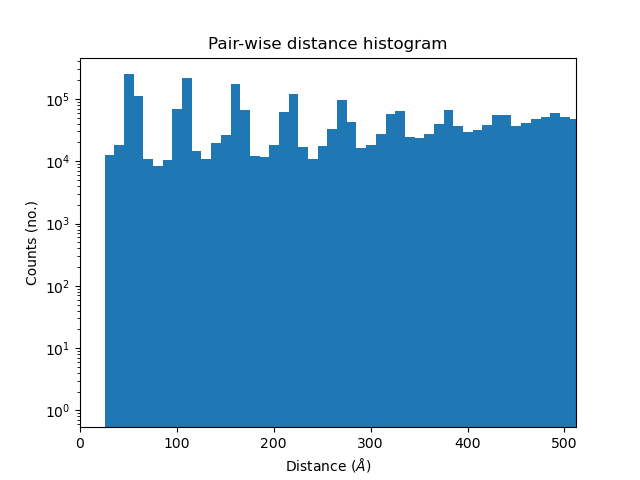

In [29]:
# plot pair-wise distances (in Angstroms)
bin_width = 10
counts, bins = np.histogram(dist_list, np.arange(min(dist_list), max(dist_list), bin_width))
plt.figure(1)
plt.stairs(counts,bins,fill=True)
plt.title("Pair-wise distance histogram")
plt.ylabel("Counts (no.)")
plt.xlabel("Distance ($\AA$)")
plt.xlim([0,512])
plt.semilogy()
plt.show()

In the above case, the filament radius corresponds to the second major peak of ~110-120 Angstroms.

### The actual filament assignment cell:

In [35]:
# filamentID assignment
distance_threshold = 110
uid_to_filamentIDs = {}
for micrograph_df in micrograph_df_list:
    points = micrograph_df[['X','Y','uid']].values
    uid_to_filamentIDs.update(make_filaments(points,distance_threshold))

(Optional): plotting the distribution of filaments_id

<IPython.core.display.Javascript object>


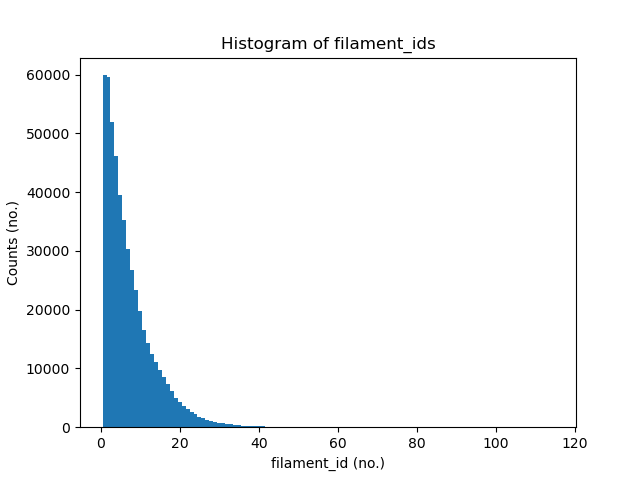

In [36]:
plt_dict = Counter(uid_to_filamentIDs.values())
plt.figure(2)
plt.bar(plt_dict.keys(),plt_dict.values(),width=1)
plt.title("Histogram of filament_ids")
plt.ylabel("Counts (no.)")
plt.xlabel("filament_id (no.)")
plt.show()

(Optional): Interactive plotting of results. Scatter plots per micrograph with points colored by filament_id

In [37]:
# update the particle dataframe with a new field for the filament id
filament_df = particles_df.copy()
filament_df['filament/filament_id'] = filament_df['uid'].map(uid_to_filamentIDs)

In [38]:
# need a new dataframe list since it now contains filament_ids
micrograph_df_list_fIDs = make_dataframe_list(filament_df,'location/micrograph_uid')

<IPython.core.display.Javascript object>


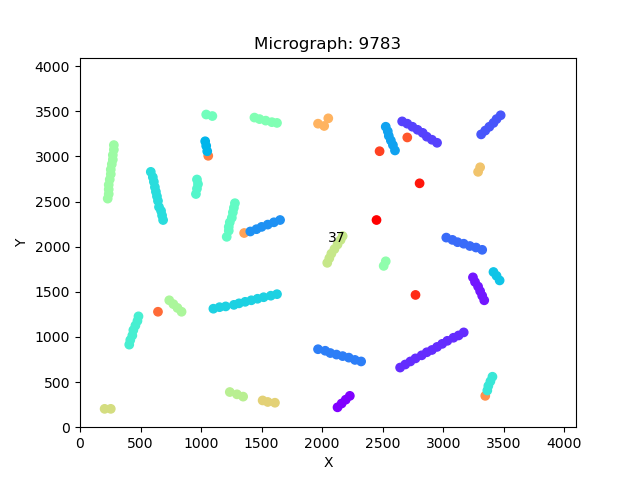

interactive(children=(IntSlider(value=0, description='Index', max=10642), Output()), _dom_classes=('widget-int…

In [39]:
# Interactive plot
# plot points and color by filament_id
n_samples = len(micrograph_df_list_fIDs)
fig,ax = plt.subplots()

# Create a scatter plot function
def update_plot(ind):
    ax.clear()
    ax.scatter(
        micrograph_df_list_fIDs[ind]['X'].values,
        micrograph_df_list_fIDs[ind]['Y'].values,
        c=micrograph_df_list_fIDs[ind]['filament/filament_id'].values,
        cmap='rainbow',
    )
    filament_count = len(set(micrograph_df_list_fIDs[ind]['filament/filament_id'].values))
    ax.set_xlim([0, 4096])
    ax.set_ylim([0, 4096])
    ax.set_title(f'Micrograph: {ind}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.annotate(filament_count,xy=(2048,2048)) # number of assigned filaments in micrograph
    plt.show()

# Create a slider widget
slider = widgets.IntSlider(value=0, min=0, max=n_samples - 1, step=1, description='Index')
widgets.interactive(update_plot, ind=slider)

There is a notable trade off between broken filaments at shorter distances (e.g., 110) and excessive branching of filaments at longer distances (e.g., 130). Being more conservative to avoid branching seems like a better choice, since it avoid skewing directionality of entire filaments versuses losing strength of priors on a few distal points from a filament core. Also, regardless of distance threshold, there seem to be some points recalcitrant to filament assignment. As in these points will overlap with a filament, but will not be co-assigned. There is probably some weird floating-point shenanigans going on...

### Assignment of filament_ids back to the CS metadata (Input passthrough file goes below):

Below is using the passthrough file of a curated version of the dataset, rather than the extraction metadata. This is because it had already been extensively curated. Ideally, would have run this procedure earlier in the workflow, but no matter.

In [102]:
passthrough_fn = 'J111_passthrough_particles.cs'
passthrough_dataset = cs.Dataset.load(passthrough_fn)
passthrough_dataset.add_fields([('filament/filament_uid', "u8")]); # initialize empty field uint64)

In [103]:
# List of filament_ids that matches row-wise with the dataset
filament_id_list = []
for row in passthrough_dataset.rows():
    uid = np.float64(row['uid']) # dataset entires are uint64, but dict keys are float64
    filament_id_list.append(uid_to_filamentIDs[uid])

In [104]:
# assign filament_ids to empty field
passthrough_dataset['filament/filament_uid'] = filament_id_list

In [105]:
# save file
passthrough_dataset.save('J111_passthrough_with_filamentIDs.cs')

Import sanity-check

In [108]:
imported_fn = '/projects/230613_CHMP1b_Iggy_23004913_02_copolymer_withDNA/CS-230613-chmp1b-iggy-23004913-02-copolymer-withdna/J216/J111_passthrough_with_filamentIDs.cs'
imported_dataset = cs.Dataset.load(imported_fn)

In [110]:
imported_dataset['filament/filament_uid'].dtype

dtype('uint64')